# Low-Density Parity-Check (LDPC)

Mã kiểm tra chẵn lẻ mật độ thấp (LDPC) được hỗ trợ cho chuẩn 5G.

Bước đầu tiên là import thư viện hỗ trợ mã hóa và giải mã.

In [ ]:
try:
    import sionna
except ImportError as e:
    import os
    os.system("pip install sionna")
    import sionna

Sau đó là tạo phần `encoder` và `decoder`. Dưới đây là một ví dụ.

In [ ]:
encoder = sionna.fec.ldpc.LDPC5GEncoder(k = 100, # số information bits (input)
                                    n = 200) # số codeword bits (output)


decoder = sionna.fec.ldpc.LDPC5GDecoder(encoder = encoder,
                                    num_iter = 20, # number of BP iterations
                                                   # - số lần lặp giải mã
                                    return_infobits = True)

Từ đó có thể được sử dụng encoder và decoder như sau:
```python
# --- encoder ---
# u là mảng chứa thông tin các bit sẽ được mã hóa và có dạng [...,k].
# c là mảng chứa các từ mã đã đượ mã hóa sau LDPC và có dạng [...,n].
c = encoder(u)

# --- decoder ---
# llr chứa các tỷ lệ log-likelihood từ demapper và có dạng [...,n].
# u_hat chứa thông tin được giải mã qua LDPC [...,k].
u_hat = decoder(llr)
```

## LDPC Encoder

```
class
sionna.fec.ldpc.encoding.LDPC5GEncoder(k, n, num_bits_per_symbol=None, dtype=tf.float32, **kwargs)
```

5G NR LDPC Encoder được dựa theo tài liệu 3GPP TS 38.212 bao gồm cả rate-matching.

Chi tiết về các parameters:
- **k** (int) - Số bit thông tin trên mỗi từ mã
- **n** (int) - Số từ mã mong muốn
- **num_bits_per_symbol** (int hoặc None) - Số bit trên mỗi QAM symbol
- **dtype** (tf.DType) - Mặc định là tf.float32. Xác định kiểu dữ liệu đầu ra của mỗi lớp

## LDPC Decoder

```
class
sionna.fec.ldpc.decoding.LDPC5GDecoder(encoder, trainable=False, cn_type='boxplus-phi', hard_out=True, track_exit=False, return_infobits=True, prune_pcm=True, num_iter=20, stateful=False, output_dtype=tf.float32, **kwargs)
```

Các parameters:
- **encoder** (LDPC5GEncoder) - Bộ mã hóa được gọi trước đó
- **trainable** (bool) - Mặc định là False. Nếu True, là các dữ liệu đầu ra có thể training được
- **cn_type** (str) - Một chuỗi ký tự, là một trong các giá trị: {“boxplus”, “boxplus-phi”, “minsum”}. Trong đó “boxplus” thực hiện single-parity-check APP decoding rule. “boxplus-phi” triển khai phiên bản ổn định hơn của boxplus. “minsum” thực hiện min-approximation của quy tắc cập nhật CN
- **track_exit** (bool)
- **return_infobits** (bool) – Mặc định là True. Nếu True sẽ trả về k bit dữ liệu. Nếu không sẽ trả về tất cả n bit
- **prune_pcm** (bool)
- **num_iter** (int) - Số lần lặp bộ giải mã (hiện chưa sử dụng vội)

# Mã hóa kênh trong 5G và Rate-Matching: Polar với LDPC

Mục dưới đây sẽ làm các phần sau:
- Mã LDPC, giá trị k lên tới 8448 bit thông tin trên mỗi từ mã
- Mã Polar bao gồm ghép CRC và rate-matching cho 5G

## Cấu hình và sử dụng GPU

Mô phỏng này ưu tiên dùng GPU vì khối lượng tính toán lớn và đảm bảo tốc độ chạy.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time

gpus = tf.config.list_physical_devices('GPU')
print('Số lượng GPU trên thiết bị :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Chỉ GPU số', gpu_num, 'được sử dụng.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

from sionna.mapping import Constellation, Mapper, Demapper
from sionna.fec.polar import PolarEncoder, Polar5GEncoder, PolarSCLDecoder, Polar5GDecoder, PolarSCDecoder
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.fec.polar.utils import generate_5g_ranking, generate_rm_code
from sionna.fec.conv import ConvEncoder, ViterbiDecoder, BCJRDecoder
from sionna.fec.turbo import TurboEncoder, TurboDecoder
from sionna.fec.linear import OSDecoder
from sionna.utils import BinarySource, ebnodb2no
from sionna.utils.metrics import  count_block_errors
from sionna.channel import AWGN
from sionna.utils.plotting import PlotBER

Số lượng GPU trên thiết bị : 1
Chỉ GPU số 0 được sử dụng.
Physical devices cannot be modified after being initialized


## Hiệu suất BER của mã hóa 5G

Đầu tiên chúng ta phân tích vào mã hóa tin có độ dài ngắn, ví dụ như trong IoT và truyền thông có độ trễ cực thấp (ultra-reliable low-latency communications  - URLLC).

Class `PlotBER` sẽ hỗ trợ vẽ đồ thị về BER với những dữ liệu của mình.

Sionna API cho phép chuyển tiếp đối tượng encoder tới khởi tạo decoder để phục vụ cho quá trình mô phỏng.

Dưới đây là tạo mô hình mô phỏng.


In [ ]:
class System_Model(tf.keras.Model):
    """Model hệ thống cho mô phỏng BER trong mã hóa kênh.

    Model này cho phép mô phỏng BER qua kênh AWGN với điều chế QAM.
    Các lớp encoder/decoder FEC tùy ý có thể được sử dụng để khởi
    tạo model này.

    Parameters
    ----------
        k: int
            số bit thông tin trên mỗi từ mã.

        n: int
            chiều dài từ mã.

        num_bits_per_symbol: int
            lượng bit trên mỗi QAM symbol.

        encoder: Keras layer
            Lớp thực hiện encoder.

        decoder: Keras layer
            Lớp thực hiện decoder llr tensors.

        demapping_method: str
            Phương pháp ánh xạ. Có thể là "app" hoặc "maxlog".

        sim_esno: bool
            Mặc định là False. Nếu True, không có sự điều chỉnh tỷ lệ nào được thực hiện cho phép tính SNRSNR.

         cw_estiamtes: bool
            Mặc định là False. Nếu True, thay vì việc ước tính như trước, thông tin từ mã được trả về.
    Input
    -----
        batch_size: int hoặc tf.int
            batch_size sử dụng cho việc mã hóa.

        ebno_db: float hoặc tf.float
            Xác định SNR mô phỏng.

    Output
    ------
        (u, u_hat):
            Tuple:

        u: tf.float32
            Một tensor dạng `[batch_size, k] chỉ chứa bit 0 và 1 chứa các thông tin bit được truyền.

        u_hat: tf.float32
            Một tensor dạng `[batch_size, k] chỉ chứa bit 0 và 1 chứa bit thông tin được ước tính.
    """
    def __init__(self,k,n,num_bits_per_symbol,encoder,decoder,demapping_method="app",sim_esno=False,cw_estimates=False):
        super().__init__()
        # các giá trị chính
        self.k = k
        self.n = n
        self.sim_esno = sim_esno
        self.cw_estimates=cw_estimates
        self.num_bits_per_symbol = num_bits_per_symbol

        # khởi tạo nguồn
        self.source = BinarySource()

        # Khởi tạo ánh xạ và giải mã
        self.constellation = Constellation("qam", num_bits_per_symbol=self.num_bits_per_symbol)
        self.mapper = Mapper(constellation=self.constellation)
        self.demapper = Demapper(demapping_method, constellation=self.constellation)

        # kênh truyền, có thể được thay thế bằng các mô hình phức tạp hơn
        self.channel = AWGN()

        # FEC encoder / decoder
        self.encoder = encoder
        self.decoder = decoder

    @tf.function() # bật chế độ graph để tăng dữ liệu truyền nhận (thông lượng)
    def call(self, batch_size, ebno_db):

        # tính phương sai noise
        if self.sim_esno:
                no = ebnodb2no(ebno_db,
                       num_bits_per_symbol=1,
                       coderate=1)
        else:
            no = ebnodb2no(ebno_db,
                           num_bits_per_symbol=self.num_bits_per_symbol,
                           coderate=self.k/self.n)

        u = self.source([batch_size, self.k]) # tạo dữ liệu ngẫu nhiên, ném vào nguồn
        c = self.encoder(u) # mã hóa kênh
        x = self.mapper(c) # map c tới symbols x

        y = self.channel([x, no]) # truyền qua kênh AWGN

        llr_ch = self.demapper([y, no]) # demap y tới LLRs
        u_hat = self.decoder(llr_ch) # chạy FEC giải mã kênh (incl. rate-recovery)

        if self.cw_estimates:
            return c, u_hat

        return u, u_hat


Khởi tạo các trường hợp mã hóa khác nhau cho trình mô phỏng này. Lưu ý: Mộ số trường hợp không trong 5G nhưng sẽ được đưa vào đây để so sánh.

In [ ]:
k = 64 # số bit thông tin trên mỗi từ mã
n = 128 # độ dài từ mã mong muốn
codes_under_test = []

# 5G LDPC codes với 20 BP iterations
enc = LDPC5GEncoder(k=k, n=n)
dec = LDPC5GDecoder(enc, num_iter=20)
name = "5G LDPC BP-20"
codes_under_test.append([enc, dec, name])

# Polar Codes (SC decoding)
enc = Polar5GEncoder(k=k, n=n)
dec = Polar5GDecoder(enc, dec_type="SC")
name = "5G Polar+CRC SC"
codes_under_test.append([enc, dec, name])

# Polar Codes (SCL decoding) với list size 8.
# Sẽ tự động thêm CRC bởi layer.
enc = Polar5GEncoder(k=k, n=n)
dec = Polar5GDecoder(enc, dec_type="SCL", list_size=8)
name = "5G Polar+CRC SCL-8"
codes_under_test.append([enc, dec, name])

### Các trường hợp khác không dùng trong 5G

# RM codes với SCL decoding
f,_,_,_,_ = generate_rm_code(3,7) # nghĩa là k=64 và n=128 code
enc = PolarEncoder(f, n)
dec = PolarSCLDecoder(f, n, list_size=8)
name = "Reed Muller (RM) SCL-8"
# codes_under_test.append([enc, dec, name])

# Conv. code với Viterbi decoding
enc = ConvEncoder(rate=1/2, constraint_length=8)
dec = ViterbiDecoder(gen_poly=enc.gen_poly, method="soft_llr")
name = "Conv. Code Viterbi (constraint length 8)"
# codes_under_test.append([enc, dec, name])

# Turbo. codes
enc = TurboEncoder(rate=1/2, constraint_length=4, terminate=False) # không dung terminate do rate loss
dec = TurboDecoder(enc, num_iter=8)
name = "Turbo Code (constraint length 4)"
# codes_under_test.append([enc, dec, name])

Tạo Plot mới và thực hiện chạy mô phỏng kết hợp với tốc độ GPU của thiết bị (nếu có).

In [ ]:
ber_plot128 = PlotBER(f"Performance of Short Length Codes (k={k}, n={n})")

num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(0, 5, 0.5) # dải giá trị SNR để mô phỏng

# chạy mô phỏng từ các trường hợp nêu trước đó
for code in codes_under_test:
    print("\nRunning: " + code[2])
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1])

    ber_plot128.simulate(model,
                         ebno_dbs=ebno_db, # dải giá trị SNR
                         legend=code[2], # legend string
                         max_mc_iter=10, # chạy 100 lượt forward trên mỗi điểm SNR
                         num_target_block_errors=1000, # 1000 tiếp tục với SNR tiếp theo sau 1000 block lỗi
                         batch_size=10000, # batch-size trên mỗi đợt chạy forward
                         soft_estimates=False,
                         early_stop=True, # dừng mô phỏng nếu phát hiện lỗi trong quá trình chạy
                         show_fig=False,
                         add_bler=True,
                         forward_keyboard_interrupt=True);


Running: 5G LDPC BP-20
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.6583e-01 | 8.6020e-01 |      106131 |      640000 |         8602 |       10000 |         4.7 |reached target block errors
      0.5 | 1.2605e-01 | 6.9950e-01 |       80670 |      640000 |         6995 |       10000 |         0.4 |reached target block errors
      1.0 | 8.6359e-02 | 5.0150e-01 |       55270 |      640000 |         5015 |       10000 |         0.4 |reached target block errors
      1.5 | 5.0787e-02 | 3.0350e-01 |       32504 |      640000 |         3035 |       10000 |         0.4 |reached target block errors
      2.0 | 2.5281e-02 | 1.5430e-01 |       16180 |      640000 |         1543 |       10000 |         0.4 |reached target block errors
      2.5 | 1.0281e-02 | 6.3750e-02 |    

Và tỷ lệ BER và BLER

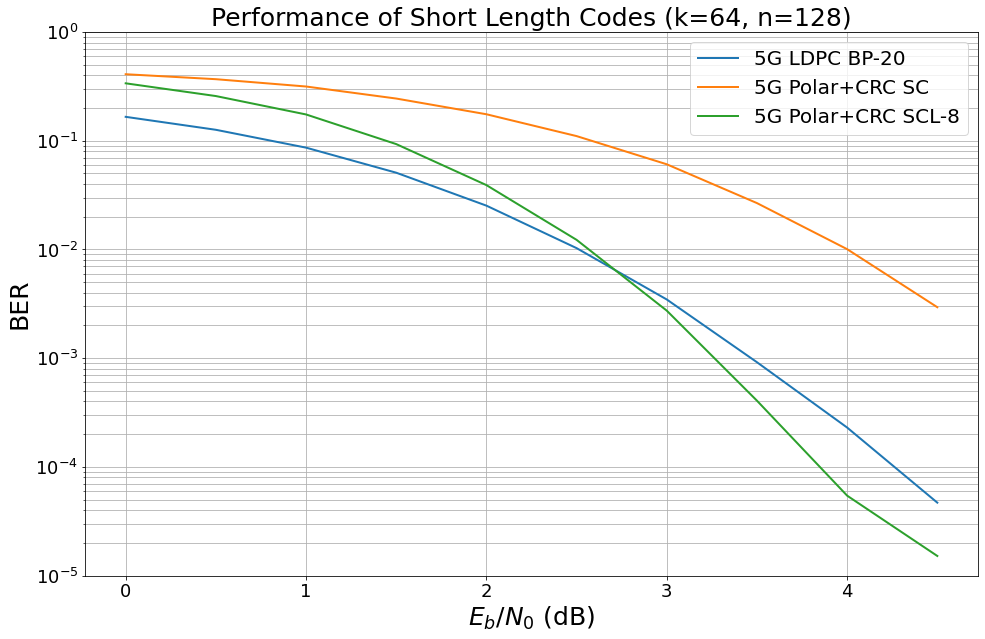

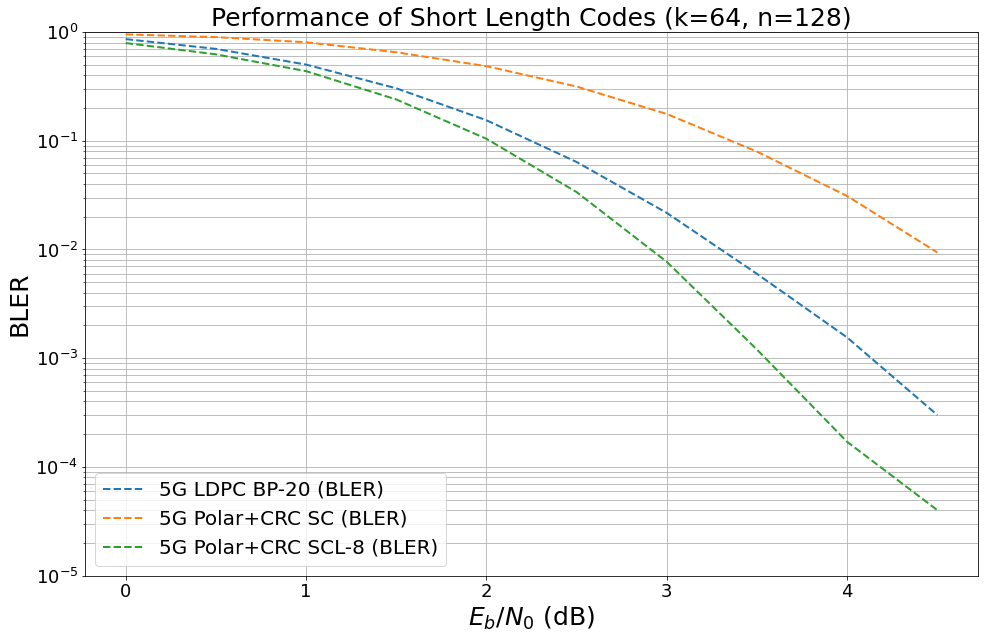

In [ ]:
# vẽ đồ thị
ber_plot128(ylim=(1e-5, 1), show_bler=False)
ber_plot128(ylim=(1e-5, 1), show_ber=False)

### Hiệu suất của việc Giải mã tối ưu

Hiệu suất tỷ lệ lỗi có thể đạt được của loại mã hóa phụ thuộc vào độ mạnh của việc xây dựng mã và hiệu suất của thuật toán giải mã trong thực tế. Dưới đây sẽ ước tính hiệu suất tối đa của tất cả các sơ đồ mã hóa trước đó bằng cách sử dụng bộ giải mã thống kê theo thứ tự (ordered statistic decoder - OSD).

In [ ]:
legends = ["5G LDPC", "5G Polar+CRC", "5G Polar+CRC", "RM", "Conv. Code", "Turbo Code"]

for idx, code in enumerate(codes_under_test):

    if idx==2:
        continue

    print("\nRunning: " + code[2])

    # khởi tạo bộ mã hóa
    encoder = code[0]
    encoder(tf.zeros((1, k)))

    # bộ giải mã với OSD
    decoder = OSDecoder(encoder=encoder, t=4)

    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=encoder,
                         decoder=decoder,
                         cw_estimates=True)

    ber_plot128.simulate(tf.function(model, jit_compile=True),
                         ebno_dbs=ebno_db,
                         legend=legends[idx]+f" OSD-{decoder.t} ",
                         max_mc_iter=100, # 1000
                         num_target_block_errors=1000,  # 1000
                         batch_size=100, # 1000
                         soft_estimates=False,
                         early_stop=True,
                         show_fig=False,
                         add_bler=True,
                         forward_keyboard_interrupt=True);


Running: 5G LDPC BP-20
Note: Required memory complexity is large for the given code parameters and t=4. Please consider small batch-sizes to keep the inference complexity small and activate XLA mode if possible.
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.0014e-01 | 4.4000e-01 |       29482 |      294400 |         1012 |        2300 |         8.7 |reached target block errors
      0.5 | 5.6813e-02 | 2.5575e-01 |       29088 |      512000 |         1023 |        4000 |         8.2 |reached target block errors
      1.0 | 2.7439e-02 | 1.2910e-01 |       27395 |      998400 |         1007 |        7800 |        16.1 |reached target block errors
      1.5 | 9.0789e-03 | 4.4900e-02 |       11621 |     1280000 |          449 |       10000 |        20.5 |reached max iter

Và vẽ đồ thị cho giải mã với OSD

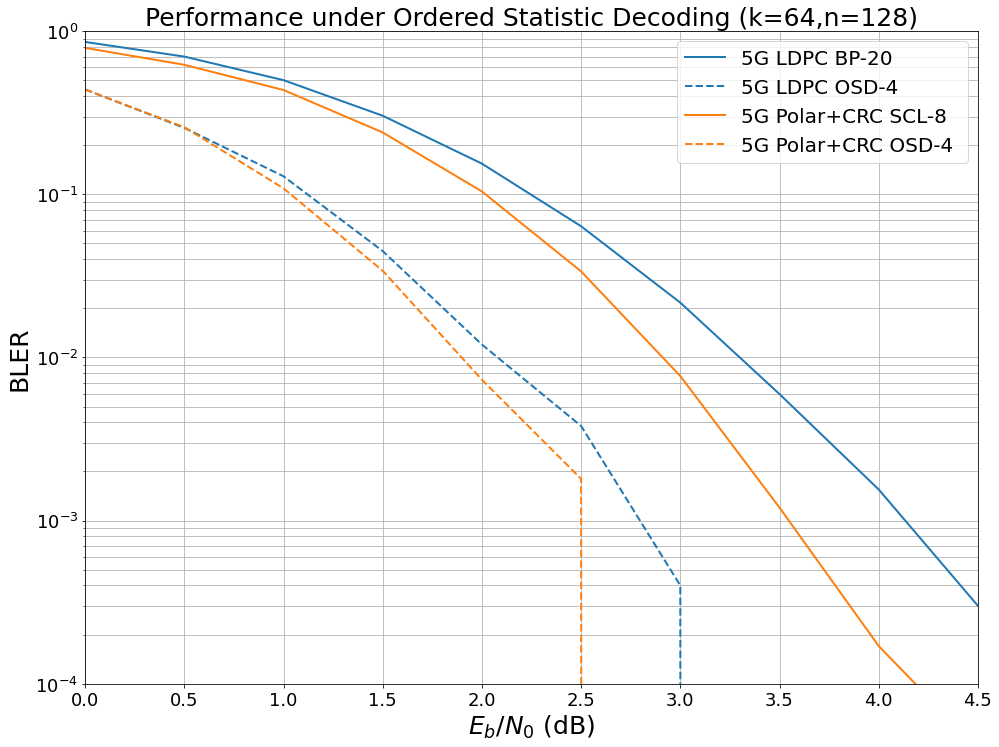

In [ ]:
plots_to_show = ['5G LDPC BP-20 (BLER)', '5G LDPC OSD-4  (BLER)', '5G Polar+CRC SCL-8 (BLER)', '5G Polar+CRC OSD-4  (BLER)', 'Reed Muller (RM) SCL-8 (BLER)', 'RM OSD-4  (BLER)', 'Conv. Code Viterbi (constraint length 8) (BLER)', 'Conv. Code OSD-4  (BLER)', 'Turbo Code (constraint length 4) (BLER)', 'Turbo Code OSD-4  (BLER)']
plots_to_show = ['5G LDPC BP-20 (BLER)', '5G LDPC OSD-4  (BLER)', '5G Polar+CRC SCL-8 (BLER)', '5G Polar+CRC OSD-4  (BLER)']

idx = []
for p in plots_to_show:
    for i,l in enumerate(ber_plot128._legends):
        if p==l:
            idx.append(i)

fig, ax = plt.subplots(figsize=(16,12))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(f"Performance under Ordered Statistic Decoding (k={k},n={n})", fontsize=25)
plt.grid(which="both")
plt.xlabel(r"$E_b/N_0$ (dB)", fontsize=25)
plt.ylabel(r"BLER", fontsize=25)

for i in range(int(len(idx)/2)):

    # non-OSD
    plt.semilogy(ebno_db,
                 ber_plot128._bers[idx[2*i]],
                 c='C%d'%(i),
                 label=ber_plot128._legends[idx[2*i]].replace(" (BLER)", ""), #remove "(BLER)" from label
                 linewidth=2)
    # OSD
    plt.semilogy(ebno_db,
                 ber_plot128._bers[idx[2*i+1]],
                 c='C%d'%(i),
                 label= ber_plot128._legends[idx[2*i+1]].replace(" (BLER)", ""), #remove "(BLER)" from label
                 linestyle = "--",
                 linewidth=2)

plt.legend(fontsize=20)
plt.xlim([0, 4.5])
plt.ylim([1e-4, 1]);

### Hiệu suất của mã LDPC dài hơn

Trong trường hợp từ mã dài hơn. Dưới đây sẽ so sánh các trường hợp LDPC khác nhau.

In [ ]:
ber_plot_ldpc = PlotBER(f"BER/BLER Performance of LDPC Codes @ Fixed Rate=0.5")

# số lượng từ mã để mô phỏng
ns = [128, 256, 512, 1000, 2000, 4000, 8000, 16000]
rate = 0.5 # tỷ lệ coderate cố định

codes_under_test = []

# 5G LDPC codes
for n in ns:
    k = int(rate*n) # tính k từ tỷ lệ rate trước đó
    enc = LDPC5GEncoder(k=k, n=n)
    dec = LDPC5GDecoder(enc, num_iter=20)
    name = f"5G LDPC BP-20 (n={n})"
    codes_under_test.append([enc, dec, name, k, n])

num_bits_per_symbol = 2 # QPSK

ebno_db = np.arange(0, 5, 0.25)

# chạy mô phỏng cho từng trường hợp chiều dài
for code in codes_under_test:
    print("Running: " + code[2])
    model = System_Model(k=code[3],
                         n=code[4],
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1])

    ber_plot_ldpc.simulate(model,
                           ebno_dbs=ebno_db,
                           legend=code[2],
                           max_mc_iter=100,
                           num_target_block_errors=500, # cố định thông số này block errors
                           batch_size=1000,
                           soft_estimates=False,
                           early_stop=True,
                           show_fig=False,
                           forward_keyboard_interrupt=True);

Running: 5G LDPC BP-20 (n=128)
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.6592e-01 | 8.6000e-01 |       10619 |       64000 |          860 |        1000 |         1.4 |reached target block errors
     0.25 | 1.4570e-01 | 7.7600e-01 |        9325 |       64000 |          776 |        1000 |         0.1 |reached target block errors
      0.5 | 1.2812e-01 | 7.0200e-01 |        8200 |       64000 |          702 |        1000 |         0.1 |reached target block errors
     0.75 | 1.0542e-01 | 5.9200e-01 |        6747 |       64000 |          592 |        1000 |         0.1 |reached target block errors
      1.0 | 8.8828e-02 | 5.2600e-01 |        5685 |       64000 |          526 |        1000 |         0.1 |reached target block errors
     1.25 | 6.5039e-02 | 3.8750e-0

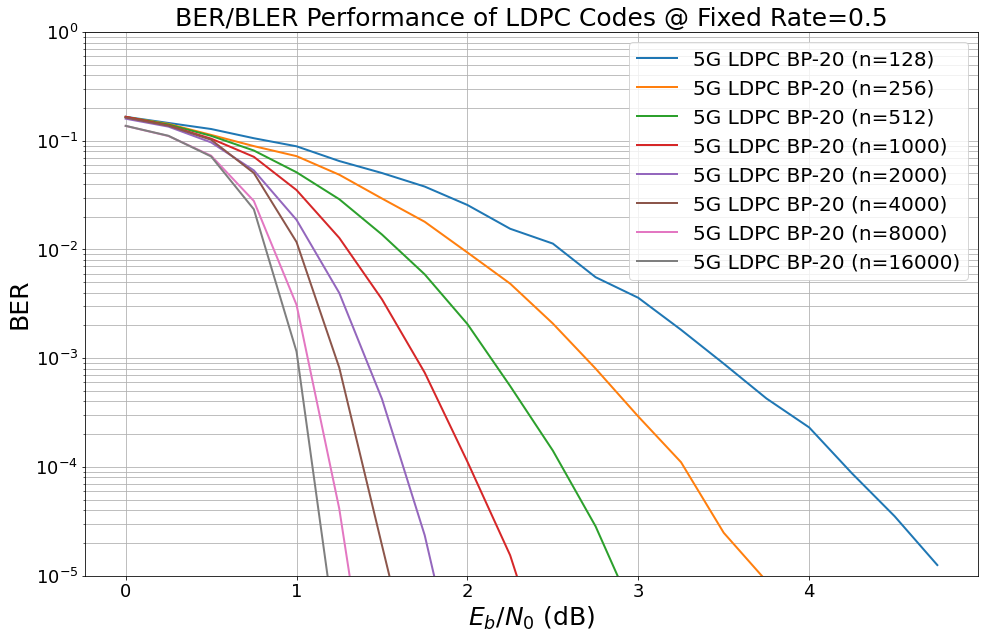

In [ ]:
# vẽ đồ thị
ber_plot_ldpc(ylim=(1e-5, 1))